In [ ]:
#@title Click to save output data and/or figures.  { run: "auto" }
save_to_file = True #@param {type:"boolean"}
save_plot = True #@param {type:"boolean"}

### In the Runtime tab click 'Run all' or press `Ctrl+F9`.

This table describes how the variables of this document relate to those in the main text.

Code name| Variable | Description
:-----------:|:----------:|----------
```g, gamma```| $\gamma$ |host clearance rate
```a, alpha```| $\alpha$ |parasite induced mortality rate
```u```| $\mu$| disease-free death rate
```bS, bSvals```| $b_{_{S}}$ |birth rate of susceptibles
```l, lvals```|$\lambda$| cost (to hosts) of adaptive immune function
```n, nvals```|$n$| cheapness of horizontal transmissibility
```v, vvals```|$v$| probability of vertical transmission given a birth

### Plots are at the end of this script.

In [ ]:
#@title Setup
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

#LIFE-HISTORY TRADE-OFFS

# Birth rate of infectives
def bi(g,l,bS): return bS - l*g**2

# Horizontal transmissibility coefficient
def beta(a,m,n): return m*a**n

# CO-EVOLVED BEST RESPONSES

# Host's best response
def gbr(a,l,n,v,u,bS): 
  return -(1-v)*(u+a) + ( ((1-v)*(u+a))**2 + (u+a-bS)/l )**.5

# Parasite's best response
def abr(g,l,n,v,u,bS):
  return (u + g - v*bi(g,l,bS))*n/(1 - n)


# ECOLOGICAL EQUILIBRIUM

def SbarUN(a,g,l,v,u,bS,m,n):
  # (Unconditional Model) Numerator of the number of suseptible hosts at equilibrium
  return (u + a + g - v*bi(g,l,bS))/beta(a,m,n)

def IbarUN(a,g,l,v,u,bS,m,n):
  # (Unconditional Model) Denominator of the number of infective hosts at equilibrium 
  return (bS-u)*SbarUN(a,g,l,v,u,bS,m,n)/(u + a - bi(g,l,bS))


# BIOLOGICAL CONSTRAINTS  

def constraint2(a,g,l,u,bS):
  return u + a - bi(g,l,bS) 

def constraint3(a,g,l,v,u,bS):
  return u + a + g - v*bi(g,l,bS)

def abr_prime(g,l,n,v,u,bS):
  return n*(1+2*v*l*g)/(1-n)

def gbr_prime(a,l,n,v,u,bS):
  numer = 2*(u+a)*(1-v)**2+1/l
  denom = 2*np.sqrt((1-v)**2*(u+a)**2+(u+a-bS)/l)
  return v-1 + numer/denom

# PARAMETERS
m       = 1 
u       = 1                            
bSvals  = np.linspace(1.2,1.48,8)                              
nvals   = np.linspace(.4,.55,8) 
lvals   = np.arange(.3,.7,.1)
vvals   = np.arange(0.01,1,0.001)     # for a quick look
# vvals   = np.arange(0.01,1,0.0001)  # fine-grained view (long runtime)

param_dim = (len(bSvals), len(lvals), len(nvals), len(vvals))

In [ ]:
#@title Search
if save_to_file:
  f = open('Unconditional_outfile.csv', 'w')
  writer = csv.writer(f)
  writer.writerow([
    'bS','u','m','n','l','v','alpha','gamma','virulence','case mortality','alpha unstable','gamma unstable'
  ])

# Initialise arrays
alpha_st        = np.full(param_dim, np.nan) # parasite-induced mortality (Nash)
gamma_st        = np.full(param_dim, np.nan) # host clearance rate (Nash)

alpha_un        = np.full(param_dim, np.nan) # parasite-induced mortality (Threshold)
gamma_un        = np.full(param_dim, np.nan) # host clearance rate (Threshold)

alpha_3         = np.full(param_dim, np.nan) # parasite-induced mortality (artifact)
gamma_3         = np.full(param_dim, np.nan) # host clearance rate (artifact)

case_mortality  = np.full(param_dim, np.nan) # probability of dying given infection 
proportion_vert = np.full(param_dim, np.nan) # proportion of infections which arose vertically
virulence       = np.full(param_dim, np.nan) # decrease in fitness due to infection


# Loop through parameters bS, n, v, and lambda.
for (h, i, j, k) in itertools.product(range(len(bSvals)), range(len(nvals)),range(len(vvals)),range(len(lvals))):
  bS = bSvals[h]
  n = nvals[i]
  v = vvals[j]
  l = lvals[k]

  # Coefficients of the cubic whose roots coincide with the gamma coordinate of the fixed points.
  p = [2*l*l*(v-1)*v*n/(1-n),
      (l*v-2*l*(1-v))*n/(1-n)-l,
      (1-2*l*(1-v)*(u-bS*v))*n/(1-n)-2*l*(1-v)*u,
      (u-bS*v)*n/(1-n)+u-bS]

  # We use the numpy tool roots to find the candidate host traits at the coevolved outcome.
  g_3, g_unstable, gamma = np.sort_complex(np.roots(p))

  # Check these candidate traits against ecological constraints presented in the main text.

  if np.imag(g_3) != 0 or np.real(g_3) < 0:
    gamma_3[h,k,i,j] = np.nan
    alpha_3[h,k,i,j] = np.nan
  else: 
    gamma_3[h,k,i,j] = np.real(g_3)
    alpha_3[h,k,i,j] = abr(np.real(g_3),l,n,v,u,bS)

  if np.imag(g_unstable) != 0 or np.real(g_unstable) < 0:
    gamma_un[h,k,i,j] = np.nan
    alpha_un[h,k,i,j] = np.nan
  else:
    gamma_un[h,k,i,j] = np.real(g_unstable)
    alpha_un[h,k,i,j] = abr(np.real(g_unstable),l,n,v,u,bS)

  if np.imag(gamma) != 0 or np.real(gamma) < 0 :
    alpha_st[h,k,i,j] = np.nan
    gamma_st[h,k,i,j] = np.nan
  else:      
    gamma = np.real(gamma)
    alpha = abr(gamma,l,n,v,u,bS)
    bI    = bi(gamma, l, bS)
    C2i   = constraint2(alpha,gamma,l,u,bS)
    C3    = constraint3(alpha,gamma,l,v,u,bS)
    C4    = alpha+u-bS
    S     = SbarUN(alpha,gamma,l,v,u,bS,m,n) 
    I     = IbarUN(alpha,gamma,l,v,u,bS,m,n)
    SN    = 1-abr_prime(gamma,l,n,v,u,bS)*gbr_prime(alpha,l,n,v,u,bS) # positive for strict Nash equilibrium

    if any(np.array([alpha, bI, C2i, C3, C4, S, I, SN]) < 0):
      alpha_st[h,k,i,j] = np.nan
      gamma_st[h,k,i,j] = np.nan
    else:        
      alpha_st[h,k,i,j] = alpha
      gamma_st[h,k,i,j] = gamma

      case_mortality[h,k,i,j] = alpha/(u+alpha+gamma)
      proportion_vert[h,k,i,j] = (v*bI)/(u+alpha+gamma)

      virulence[h,k,i,j] = (u + alpha - bI)/(u + alpha + gamma - v*bI)

  if save_to_file:
    writer.writerow([
    bS,u,m,n,l,v,
    alpha_st[h,k,i,j],gamma_st[h,k,i,j],
    virulence[h,k,i,j],case_mortality[h,k,i,j],
    alpha_un[h,k,i,j],gamma_un[h,k,i,j]
    ])

if not np.all(np.isnan(gamma_3)):
  print('Candidate third fixed point detected.')

if save_to_file:
  f.close()

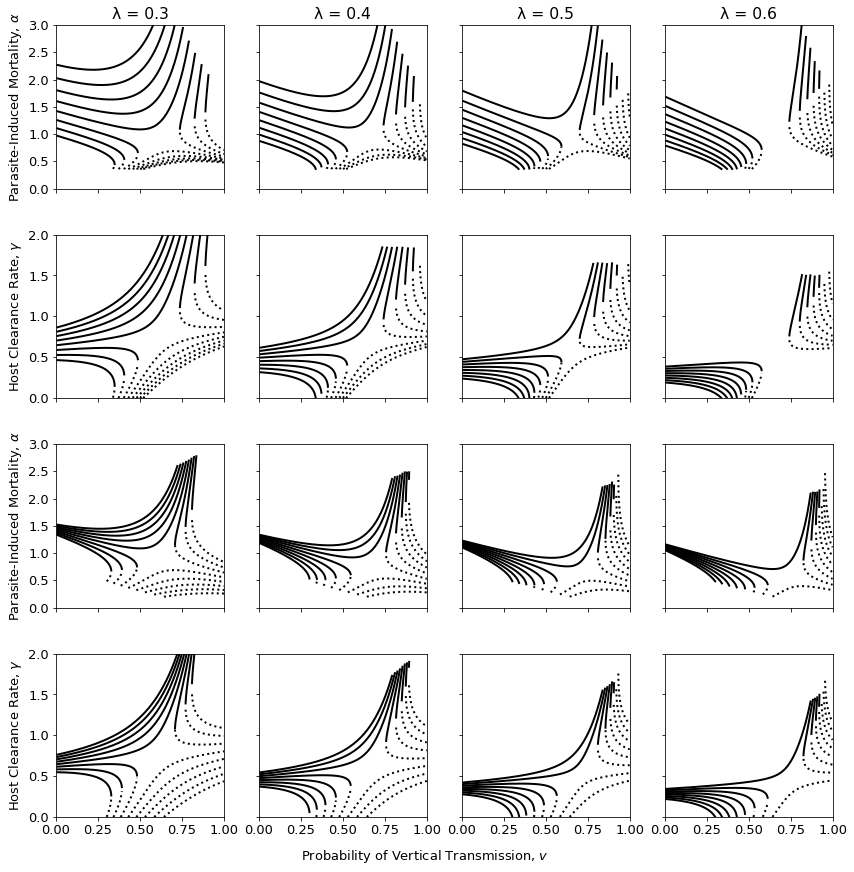

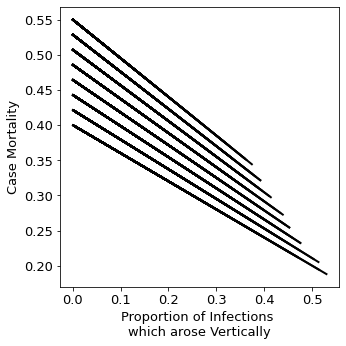

In [ ]:
#@title Plot
plt.rcParams.update({'font.size': 13, 'lines.linewidth': 2})

# FIGURE 1
fig, ax = plt.subplots(4,4,figsize = (12,12), sharey='row', sharex = True)

for k in range(len(lvals)):
  for i in range(len(nvals)):
    ax[0,k].set_title(fr'λ = {lvals[k]:.1f}')

    ax[1,k].plot(vvals, gamma_st[4,k,i,:], 'k')
    ax[0,k].plot(vvals, alpha_st[4,k,i,:], 'k')  

    ax[1,k].plot(vvals, gamma_un[4,k,i,:], 'k:')
    ax[0,k].plot(vvals, alpha_un[4,k,i,:], 'k:')

  for h in range(len(bSvals)):

    ax[3,k].plot(vvals, gamma_st[h,k,3,:], 'k')
    ax[2,k].plot(vvals, alpha_st[h,k,3,:], 'k')  

    ax[3,k].plot(vvals, gamma_un[h,k,3,:], 'k:')
    ax[2,k].plot(vvals, alpha_un[h,k,3,:], 'k:')

fig.text(0.5, -0.01, 'Probability of Vertical Transmission, $v$', ha='center')

ax[0,0].set_ylabel(f'Parasite-Induced Mortality, ${chr(945)}$')
ax[1,0].set_ylabel('Host Clearance Rate, $\gamma$')

ax[2,0].set_ylabel(f'Parasite-Induced Mortality, ${chr(945)}$')
ax[3,0].set_ylabel('Host Clearance Rate, $\gamma$')

ax[0,0].set_xlim(0,1)

ax[0,0].set_ylim(0,3)    
ax[1,0].set_ylim(0,2)
ax[2,0].set_ylim(0,3)    
ax[3,0].set_ylim(0,2)

fig.tight_layout()
if save_plot:
  fig.savefig('ESS.svg', dpi=600)

# FIGURE 2
fig, ax = plt.subplots(1,1,figsize = (5,5))

ax.set_ylabel('Case Mortality')
ax.set_xlabel('Proportion of Infections \nwhich arose Vertically')
for (h, i, k) in itertools.product(range(len(bSvals)), range(len(nvals)),range(len(lvals))):
  ax.plot(proportion_vert[h,k,i,:], case_mortality[h,k,i,:],'k')

fig.tight_layout()
if save_plot:
  fig.savefig('CaseMortality_vs_ProportionVertical.svg', dpi=600)